In [150]:
import matplotlib.pyplot as plt
%matplotlib inline

import math
import numpy as np

import asyncio
import concurrent.futures

import predict

168


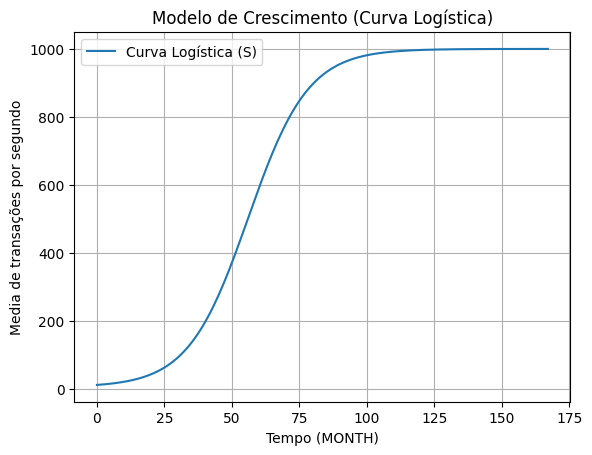

In [151]:
def logistic_curve(t, P0, K, r, t0):
    return P0 + (K - P0) / (1 + np.exp(-r * (t - t0)))

# Dados de exemplo de tempo (t)
global PREDICT_TYPE
PREDICT_TYPE = 'MONTH' #'DAY':'WEEK':'MONTH':'YEAR'
A = 168 

t = np.linspace(0, A - 1, A)
print(len(t))

# Parâmetros da curva logística
P0 = 5  # Transações inicial
K = 1000  # Valor máximo transações estimado
r =  0.09 # Taxa de crescimento
t0 = A / 3     # Ponto de inflexão -> Meio

# Calcula a população usando a função da curva logística
global rate_transactions
AVG_RATE_TRANSACTIONS = logistic_curve(t, P0, K, r, t0)

# Plotagem da curva logística
plt.plot(t, AVG_RATE_TRANSACTIONS, label='Curva Logística (S)')
plt.xlabel(f'Tempo ({PREDICT_TYPE})')
plt.ylabel('Media de transações por segundo')
plt.title('Modelo de Crescimento (Curva Logística)')
plt.legend()
plt.grid(True)
plt.show()

In [152]:

def expand_transations_by_period(predict_type, rate_transations_per_second):
    SECONDS_PER_DAY  = 86400
    return {
    'DAY': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY,
    'WEEK': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 7,
    'MONTH': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 30,
    'YEAR': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 30 * 12
    }[predict_type](rate_transations_per_second)

total_transactions_by_period = expand_transations_by_period(PREDICT_TYPE, AVG_RATE_TRANSACTIONS)

# Storage e Transações

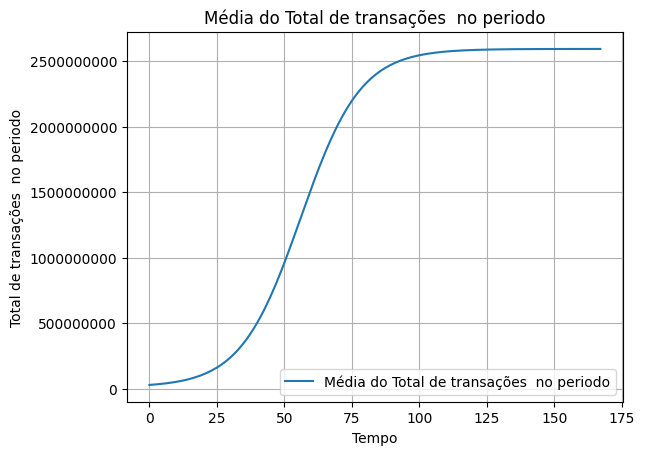

In [153]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()
ax.plot(t, total_transactions_by_period, label='Média do Total de transações  no periodo')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de transações  no periodo')
plt.title('Média do Total de transações  no periodo')
plt.legend()
plt.show()

In [154]:

blockchain_predict = predict.blockchain_predict()


def estimate_blocks(blockchain_predict, avg_tps, total_transations_period):
    total_blocks = None
    batch_type  = ""
    #Qual o tempo necessário para fechar um bloco para max_message
    time_to_batch_messages = blockchain_predict.max_message_count  / avg_tps

    #Quantas transações eu preciso para fechar um bloco para max_bytes
    aggregate_total_transations_if_batch_max_bytes = blockchain_predict.absolute_max_bytes / blockchain_predict.transation_size
    time_to_batch_bytes  = aggregate_total_transations_if_batch_max_bytes / avg_tps
    total_blocks = None
    if time_to_batch_messages >= blockchain_predict.batch_timeout and \
        time_to_batch_bytes >=  blockchain_predict.batch_timeout:

        #calcular por batchtimeout
        aggregate_total_transations_if_batch_timeout = blockchain_predict.batch_timeout * avg_tps
        total_blocks = total_transations_period / aggregate_total_transations_if_batch_timeout
        batch_type = "batch_timeout"

    elif time_to_batch_messages < time_to_batch_bytes:
        total_blocks = total_transations_period / time_to_batch_messages
        batch_type = "batch_message"
        #batch messages
    
    elif time_to_batch_bytes    < time_to_batch_messages:
        total_blocks = total_transations_period / time_to_batch_bytes
        batch_type = "batch_bytes"
        #batch bytes
    else:
        raise Exception
        
    
    return total_blocks, batch_type

StorageDemand = []


for i_period in range(0,A):
    avg_t = AVG_RATE_TRANSACTIONS[i_period]
    total_transations_by_period = total_transactions_by_period[i_period]
    print(avg_t)
    print(total_transations_by_period)

    i_storage_demand = predict.StorageDemand()
    i_storage_demand.period                       = i_period    
    i_storage_demand.total_transactions           = total_transations_by_period
    i_storage_demand.total_blocks, i_storage_demand.batch_type                 = estimate_blocks(blockchain_predict, avg_t, total_transations_by_period)
    i_storage_demand.calculated_total_size_blocks = (i_storage_demand.total_blocks * blockchain_predict.calculate_block_headers_size()) + (i_storage_demand.total_transactions * blockchain_predict.transation_size)
    
    StorageDemand.append(i_storage_demand)
    


11.39994792458404
29548665.020521834
11.998419219220185
31099902.616218723
12.652421502100797
32795076.533445265
13.367022725633165
34647322.90484116
14.147736840451655
36670933.890450686
15.000559814056388
38881451.038034156
15.932007917440215
41295764.52200504
16.94915828837775
43932218.28347512
18.059691745417283
46810721.0041216
19.27193778317066
49952862.733978346
20.594921625718328
53382036.853861906
22.038413149149097
57123566.88259446
23.61297740458283
61204837.43267869
25.33002637748276
65655428.37043532
27.201871505537078
70507250.94235212
29.24177634370146
75794684.2828742
31.464008608981537
81554710.31448014
33.88389065715907
87827044.5833563
36.51784723716112
94654260.03872162
39.38344913484513
102081900.15751858
42.4994510560629
110158577.13731503
45.88582180946269
118936050.1301273
49.5637645345378
128469277.673522
53.555724383806
138816437.60282516
57.885380716073406
150038906.81606227
62.577620499979204
162201192.3359461
67.65848927671152
175370804.20523626
73.15511570

In [155]:
for s in StorageDemand:
    atributos = vars(s)
    # Iterando sobre o dicionário e imprimindo os atributos
    for chave, valor in atributos.items():
        print(f"{chave}: {valor}")

total_blocks: 4320.0
total_transactions: 29548665.020521834
calculated_total_size_blocks: 35932006104.95455
batch_type: batch_timeout
period: 0
total_blocks: 4320.000000000001
total_transactions: 31099902.616218723
calculated_total_size_blocks: 37818311021.32197
batch_type: batch_timeout
period: 1
total_blocks: 4320.0
total_transactions: 32795076.533445265
calculated_total_size_blocks: 39879642504.66944
batch_type: batch_timeout
period: 2
total_blocks: 4320.0
total_transactions: 34647322.90484116
calculated_total_size_blocks: 42131974092.28685
batch_type: batch_timeout
period: 3
total_blocks: 4319.999999999999
total_transactions: 36670933.890450686
calculated_total_size_blocks: 44592685050.78803
batch_type: batch_timeout
period: 4
total_blocks: 67636.88419869011
total_transactions: 38881451.038034156
calculated_total_size_blocks: 47292830744.015686
batch_type: batch_bytes
period: 5
total_blocks: 76297.39074160943
total_transactions: 41295764.52200504
calculated_total_size_blocks: 50230

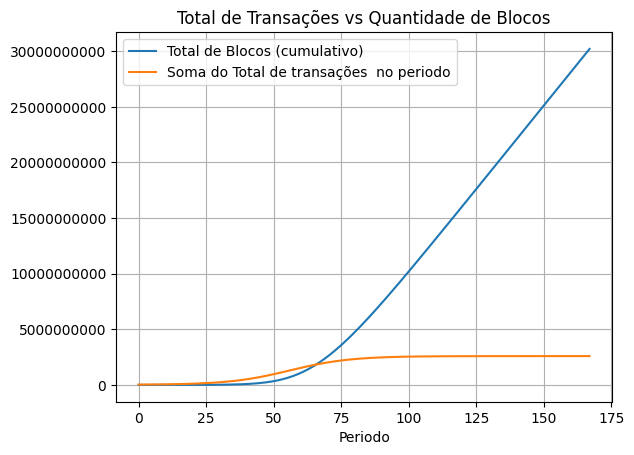

In [156]:
i_period           = np.array([s.period for s in StorageDemand])
cumulative_blocks  = np.cumsum( np.array([s.total_blocks for s in StorageDemand]) )

# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()
ax.plot(i_period, cumulative_blocks, label='Total de Blocos (cumulativo)')

ax.plot(t, total_transactions_by_period, label='Soma do Total de transações  no periodo')

ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Periodo')
plt.ylabel('')
plt.title('Total de Transações vs Quantidade de Blocos')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


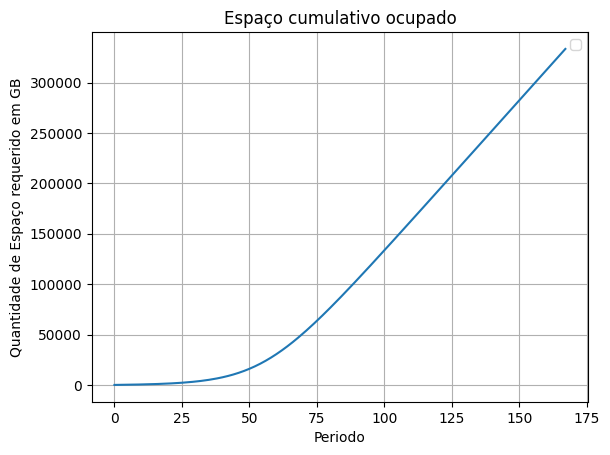

In [157]:
BYTE_TO_GIGA =  1024 * 1024 * 1024
cumulative_size_GB  = np.cumsum( np.array([s.calculated_total_size_blocks for s in StorageDemand]) /  BYTE_TO_GIGA )

fig, ax = plt.subplots()
ax.plot(i_period, cumulative_size_GB, label='')

ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Periodo')
plt.ylabel('Quantidade de Espaço requerido em GB')
plt.title('Espaço cumulativo ocupado')
plt.legend()
plt.show()

# CPU

Analise conforme TPS

In [162]:
aggregate_total_required_vcpu = []
vCPU_BASE     =  2
vCPU_BASE_TPS = 200 # 2vcpu = 200

for tps in AVG_RATE_TRANSACTIONS:
    target_required_vcpu  = vCPU_BASE

    required_vcpu_current_tps = tps / vCPU_BASE_TPS

    if int(required_vcpu_current_tps) > 1:
        target_required_vcpu = vCPU_BASE + (vCPU_BASE * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu.append(target_required_vcpu)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


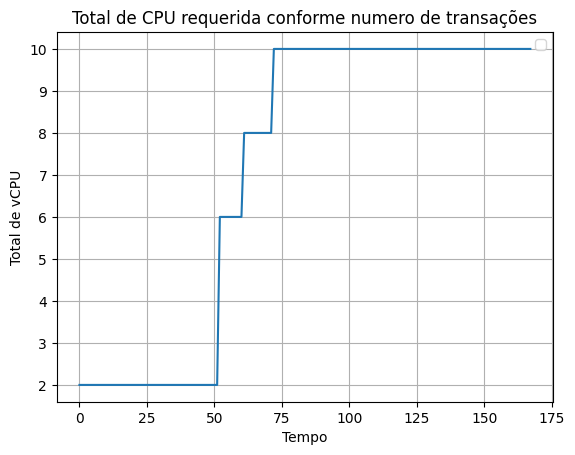

In [163]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()
ax.plot(t, aggregate_total_required_vcpu, label='')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida')
plt.legend()
plt.show()

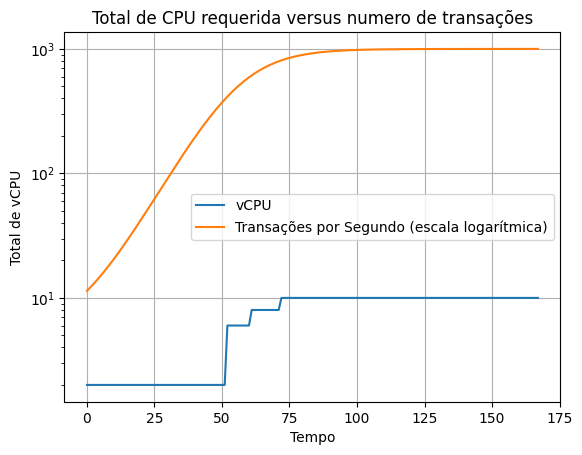

In [167]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()

plt.semilogy(t, AVG_RATE_TRANSACTIONS, label='Transações por Segundo (escala logarítmica)')
plt.plot(t, aggregate_total_required_vcpu, label='vCPU')


ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida versus numero de transações')
plt.legend()
plt.show()